## **Download**

In [ ]:
import requests
url = 'http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat'
r = requests.get(url, allow_redirects=True)
open('/content/drive/MyDrive/Colab Notebooks/Deep/Project/Dataset/nyu_depth_v2_labeled.mat', 'wb').write(r.content)


## **Imports**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models import densenet169
from torchvision import transforms

import h5py
import numpy as np
import gc
from tqdm import tqdm

import matplotlib.pyplot as plt


## **Models**

In [2]:
class LabeledDataset(Dataset):

  def __init__(self, path):
    self.file = h5py.File(path, mode='r')
    self.images = self.file['images']
    self.depths = self.file['depths']
    self.data_size = len(self.images)

  def close(self):
    self.file.close()

  def __len__(self):
    return self.data_size

  def __getitem__(self, idx):
    return self.images[idx].transpose(0, 2, 1) / 255.0, 10.0 / self.depths[idx].T


class Upsample(nn.Module):

  def __init__(self, in_channels, out_channels, with_concat=True):
    super(Upsample, self).__init__()

    self.convs = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.LeakyReLU(negative_slope=0.2, inplace=True)
    )
    self.with_concat = with_concat

  def forward(self, input, concat_input):
    
    if self.with_concat:
      return self.convs(torch.cat([F.interpolate(input, size=concat_input.shape[2:], mode='bilinear', align_corners=True), concat_input], dim=1))
    else:
      return self.convs(F.interpolate(input, size=concat_input.shape[2:], mode='bilinear', align_corners=True))


class DepthEstimator(nn.Module):

  def __init__(self, num_features=1664):
    super(DepthEstimator, self).__init__()

    encoder = densenet169(pretrained=True).features.float()

    self.activation = {}
    def get_activation(name):
        def hook(model, input, output):
            self.activation[name] = output.detach()
        return hook

    encoder.get_submodule('relu0').register_forward_hook(get_activation('conv1'))
    encoder.get_submodule('pool0').register_forward_hook(get_activation('pool1'))
    encoder.get_submodule('transition1').get_submodule('pool').register_forward_hook(get_activation('pool2'))
    encoder.get_submodule('transition2').get_submodule('pool').register_forward_hook(get_activation('pool3'))

    self.encoder = encoder
    self.conv2 = nn.Conv2d(encoder.get_submodule('norm5').num_features, num_features, kernel_size=1, stride=1, bias=False)
    self.up1 = Upsample(in_channels=num_features // 1 + encoder.get_submodule('transition2').get_submodule('conv').out_channels, out_channels=num_features // 2, with_concat=True)
    self.up2 = Upsample(in_channels=num_features // 2 + encoder.get_submodule('transition1').get_submodule('conv').out_channels, out_channels=num_features // 4, with_concat=True)
    self.up3 = Upsample(in_channels=num_features // 4 + encoder.get_submodule('conv0').out_channels, out_channels=num_features // 8, with_concat=True)
    self.up4 = Upsample(in_channels=num_features // 8 + encoder.get_submodule('conv0').out_channels, out_channels=num_features // 16, with_concat=True)
    self.conv3 = nn.Conv2d(num_features // 16, 1, kernel_size=3, stride=1, padding=1, bias=False)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, input):
    encoder_out = self.encoder(input.float())
    decoder_in = self.conv2(encoder_out)
    upsampled1 = self.up1(decoder_in, self.activation['pool3'])
    upsampled2 = self.up2(upsampled1, self.activation['pool2'])
    upsampled3 = self.up3(upsampled2, self.activation['pool1'])
    upsampled4 = self.up4(upsampled3, self.activation['conv1'])
    output = F.interpolate(self.conv3(upsampled4), size=input.shape[2:], mode='bilinear', align_corners=True)

    return torch.squeeze(self.relu(output), 1)


## **Functions**

In [37]:
def train(model, num_epochs, train_dataloader, valid_dataloader, optimizer, criterion, accuracy, dict_result=None):

  if dict_result:
    pre_epoch = dict_result['epoch']

  else:
    dict_result = {'tr_loss': [], 'tr_acc': [], 'val_loss': [], 'val_acc': []}
    pre_epoch = 0
  
  tr_loss = []
  tr_acc = []
  
  val_loss = []
  val_acc = []

  for epoch in range(pre_epoch, num_epochs + pre_epoch):
    
    print(f'Epoch={epoch + 1}')

    model.train()
    pbar = tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True)

    for images, depths in pbar:
      if torch.cuda.is_available():
        images = images.cuda()
        depths = depths.cuda()

      optimizer.zero_grad()
      preds = model(images)
      loss = criterion(preds, depths)
      acc = accuracy(preds, depths)

      loss.backward()
      optimizer.step()

      numpy_loss = loss.item()
      numpy_acc = acc.item()

      tr_loss.append(numpy_loss)
      tr_acc.append(numpy_acc)

      pbar.set_description(f'Training: loss={numpy_loss:.3f} acc={numpy_acc:.3f}')
    
    pbar.set_description(f'Training: loss={sum(tr_loss) / len(tr_loss):.3f} acc={sum(tr_acc) / len(tr_acc):.3f}')

    model.eval()
    val_epoch_loss = 0
    val_epoch_acc = 0
    count = 0

    pbar = tqdm(valid_dataloader, total=len(valid_dataloader), position=0, leave=True)
    for images, depths in pbar:
      if torch.cuda.is_available():
        images = images.cuda()
        depths = depths.cuda()
      
      with torch.no_grad():
        preds = model(images)
        loss = criterion(preds, depths)
        acc = accuracy(preds, depths)

        val_epoch_loss += loss.item()
        val_epoch_acc += acc.item()
        count += 1

        pbar.set_description(f'Validation: loss={val_epoch_loss / count:.3f} acc={val_epoch_acc / count:.3f}')
    
    val_epoch_loss /= count
    val_epoch_acc /= count

    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

  dict_result['epoch'] = pre_epoch + num_epochs

  dict_result['tr_loss'] = dict_result['tr_loss'] + tr_loss
  dict_result['tr_acc'] = dict_result['tr_acc'] + tr_acc

  dict_result['val_loss'] = dict_result['val_loss'] + val_loss
  dict_result['val_acc'] = dict_result['val_acc'] + val_acc

  return dict_result


def evaluation(model, test_dataloader, criterion, accuracy, dict_result, num_visual):

  model.eval()
  test_loss = 0
  test_acc = 0
  count = 0

  a1 = 0
  a2 = 0
  a3 = 0
  abs_rel = 0
  rmse = 0
  log_10 = 0

  pbar = tqdm(test_dataloader, total=len(test_dataloader), position=0, leave=True)
  for images, depths in pbar:
    if torch.cuda.is_available():
      images = images.cuda()
      depths = depths.cuda()

    with torch.no_grad():
      preds = model(images)
      loss = criterion(preds, depths)
      acc = accuracy(preds, depths)

      gt = depths.cpu().numpy()
      pred = preds.cpu().numpy()

      thresh = np.maximum((gt / pred), (pred / gt))
      a1 += (thresh < 1.25).mean()
      a2 += (thresh < 1.25 ** 2).mean()
      a3 += (thresh < 1.25 ** 3).mean()
      abs_rel += np.mean(np.abs(gt - pred) / gt)
      rmse += np.sqrt(((gt - pred) ** 2).mean())
      log_10 += (np.abs(np.log10(gt)-np.log10(pred))).mean()

      test_loss += loss.item()
      test_acc += acc.item()
      count += 1

      pbar.set_description(f'Testing: loss={test_loss / count:.3f} acc={test_acc / count:.3f}')
  
  print(f'delta1={a1 / count:.3f}, delta2={a2 / count:.3f}, delta3={a3 / count:.3f}, abs_rel={abs_rel / count:.3f}, rmse={rmse / count:.3f}, log_10={log_10 / count:.3f}')

  tr_batch = range(1, len(dict_result['tr_loss']) + 1)
  acc_batch = [i * (len(dict_result['tr_loss']) // len(dict_result['val_loss'])) for i in range(1, len(dict_result['val_loss']) + 1)]

  plt.figure()
  plt.plot(tr_batch, dict_result['tr_loss'])
  plt.plot(acc_batch, dict_result['val_loss'])
  plt.xlabel('batch')
  plt.ylabel('loss')
  plt.title('Loss')
  plt.legend(['Train', 'Valid'])
  plt.show()
  
  plt.figure()
  plt.plot(tr_batch, dict_result['tr_acc'])
  plt.plot(acc_batch, dict_result['val_acc'])
  plt.xlabel('batch')
  plt.ylabel('acc')
  plt.title('Accuracy')
  plt.legend(['Train', 'Valid'])
  plt.show()

  for index in range(min(depths.shape[0], num_visual)):
    print()
    print(f'Sample {index + 1}:')
    plt.figure()
    plt.axis('off')
    plt.title('Real RGB')
    plt.imshow(images[index].cpu().numpy().transpose(1, 2, 0))
    plt.show()

    plt.figure()
    plt.axis('off')
    plt.title('Real Depth')
    plt.imshow(10. / depths[index].cpu().numpy())
    plt.colorbar()
    plt.show()

    plt.figure()
    plt.axis('off')
    plt.title('Pred Depth')
    plt.imshow(10. / preds[index].cpu().numpy())
    plt.colorbar()
    plt.show()


## **Parameters**

In [3]:
dataset = LabeledDataset('/content/drive/MyDrive/Colab Notebooks/Deep/Project/Dataset/nyu_depth_v2_labeled.mat')
train_dataset, valid_dataset, test_dataset = random_split(dataset, [round(len(dataset) * 0.6), round(len(dataset) * 0.2), round(len(dataset) * 0.2)])

batch_size = 4
learning_rate = 0.0001
num_epochs = 5
num_visuals = 3

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)


In [27]:
dict_result = None

model = DepthEstimator()
if torch.cuda.is_available():
  model = model.cuda()

params = []
for p in model.parameters():
  if p.requires_grad:
    params.append(p)

criterion = nn.L1Loss()
optimizer = optim.Adam(params, lr=learning_rate)
accuracy = nn.MSELoss()


## **Load & Save**

In [36]:
# Save Model
PATH = '/content/drive/MyDrive/Colab Notebooks/Deep/Project/Model/model.pt'
torch.save({'dict_result': dict_result, 'model_state_dict': model.state_dict()}, PATH)

In [ ]:
# Load Model
PATH = '/content/drive/MyDrive/Colab Notebooks/Deep/Project/Model/model.pt'
model = DepthEstimator()

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
dict_result = checkpoint['dict_result']

if torch.cuda.is_available():
  model = model.cuda()
  

In [28]:
# cleaning gpu memory
gc.collect()
torch.cuda.empty_cache()

## **Training**

In [33]:
dict_result = train(model, num_epochs, train_dataloader, valid_dataloader, optimizer, criterion, accuracy, dict_result)

Epoch=6


Validation: loss=1.009 acc=1.974: 100%|██████████| 73/73 [01:15<00:00,  1.03s/it]


Epoch=7


Validation: loss=1.003 acc=2.479: 100%|██████████| 73/73 [01:13<00:00,  1.01s/it]


Epoch=8


Validation: loss=0.989 acc=2.637: 100%|██████████| 73/73 [01:14<00:00,  1.02s/it]


Epoch=9


Validation: loss=0.943 acc=2.293: 100%|██████████| 73/73 [01:14<00:00,  1.03s/it]


Epoch=10


Validation: loss=0.910 acc=2.256: 100%|██████████| 73/73 [01:15<00:00,  1.03s/it]


## **Evaluation**

Testing: loss=0.964 acc=2.364: 100%|██████████| 73/73 [01:17<00:00,  1.06s/it]


delta1=0.652, delta2=0.903, delta3=0.972, abs_rel=0.189, rmse=1.448, log_10=0.088


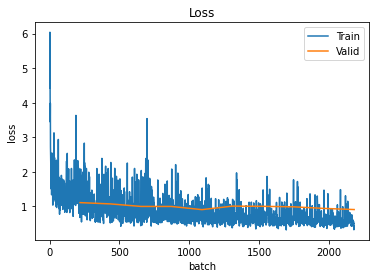

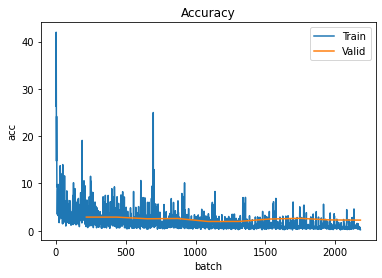


Sample 1:


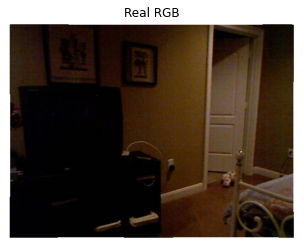

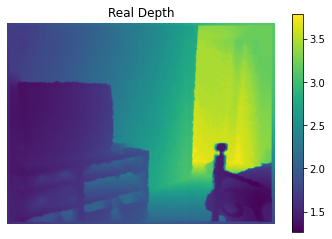

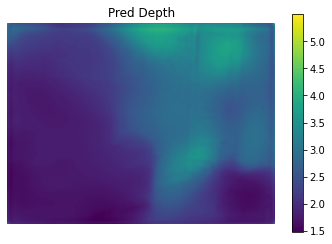


Sample 2:


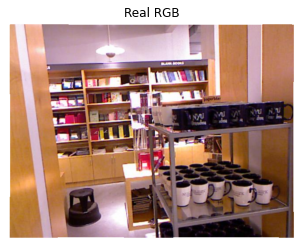

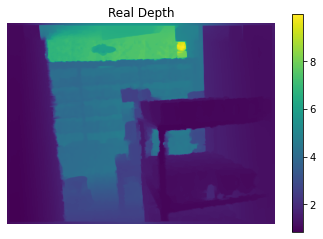

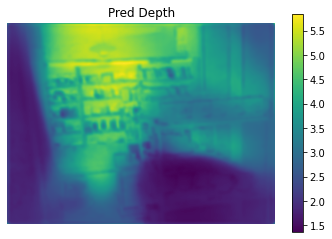

In [38]:
evaluation(model, test_dataloader, criterion, accuracy, dict_result, num_visuals)

## **Download Samples of Dataset**

In [21]:
from PIL import Image
import numpy as np
import h5py

path = '/content/drive/MyDrive/Colab Notebooks/Deep/Project/Dataset/nyu_depth_v2_labeled.mat'
f = h5py.File(path, mode='r')

for index in range(len(f['images'])):
  if np.random.rand() > 0.99:
    array = np.array(f['images'][index]).T
    img = Image.fromarray(array)
    img.save('/content/drive/MyDrive/Colab Notebooks/Deep/Project/Codes/a'+str(index)+'.jpg')
